### Here we test everything

### Code


In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
! pip install scikit-learn --quiet
! pip install cython --quiet
! pip install h5py --quiet
! pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [3]:
!pip install pytorch_lightning==1.9.3 --quiet
!pip install lightly --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.4/619.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import argparse
import pytorch_lightning as pl
import glob
import random
import numpy as np

from sklearn.svm import SVC
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('content/drive/MyDrive/VP_CrossPoint_2023/')
from drive.MyDrive.VP_CrossPoint_2023.datasets.data import *
from drive.MyDrive.VP_CrossPoint_2023.datasets.plyfile import load_ply
#from drive.MyDrive.VP_CrossPoint_2023.models.dgcnn import ResNet, DGCNN_partseg
from drive.MyDrive.VP_CrossPoint_2023.datasets.data import ModelNet40SVM
from torchvision import transforms

## ❗️❗️❗️❗️ NOTE ❗️❗️❗️❗️
The last parameter of the following cell make sure to choose the pretrained model either from the checkpoints folder (if you trained the models) or from the 'pretrained' folder (if you get just the pretrained one) you have to create and insert the model in.

Be careful then to change the folder if you moved the model somewhere else.


In [3]:
parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--num_points', type=int, default=1024, help='num of points to use')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N', help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=15, metavar='N', help='Num of nearest neighbors to use')
parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')
parser.add_argument('--model_point', type=str, default='pct',choices=['dgcnn','pct'], help='Point feature extractor')

parser.add_argument('--from_ckpt', type=bool, default=True)

#For vanilla (replica da train)
#parser.add_argument('--batch_size', type=int, default=5) # (Size of training batch)
#parser.add_argument('--val_batch_size', type=int, default=2) # (Size of validation batch)
#parser.add_argument('--test_batch_size', type=int, default=2) # (Size of testing batch)



#New arguments
# parser.add_argument('--mlp_dim', type=int, default=10)
# parser.add_argument('--num_heads', type=int, default=4)
# parser.add_argument('--dropout_rate', type=float, default=0.1)
# parser.add_argument('--attention_dropout_rate', type=float, default=0.1)
# parser.add_argument('--attention_kernel_initializer', default=nn.init.xavier_uniform_)
# parser.add_argument('--droplayer_p', type=float, default=0.0)
# parser.add_argument('--embed_dim', type=int, default=256)
# parser.add_argument('--kdim', type=int, default=256)
# parser.add_argument('--vdim', type=int, default=256)
# parser.add_argument('--share_encoder', type=bool, default=True)



args = parser.parse_args("")

### Lightning DGCNN + knn & get_graph_feature

In [17]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)


    #Mio commento----
    #device = torch.device('cuda:1')
    #----
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    #------

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)

    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()

    return feature

class DGCNN(pl.LightningModule):
    def __init__(self, args, cls = -1) -> None:
        super(DGCNN,self).__init__()
        self.k = args.k

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),self.bn1, nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),self.bn2,nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),self.bn3,nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False), self.bn4, nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False), self.bn5, nn.LeakyReLU(negative_slope=0.2))

        if cls != -1:
            self.linear1 = nn.Linear(args.emb_dims*2, 512, bias=False)
            self.bn6 = nn.BatchNorm1d(512)
            self.dp1 = nn.Dropout(p=args.dropout)
            self.linear2 = nn.Linear(512, 256)
            self.bn7 = nn.BatchNorm1d(256)
            self.dp2 = nn.Dropout(p=args.dropout)
            self.linear3 = nn.Linear(256, output_channels)

        self.cls = cls

        self.inv_head = nn.Sequential(
              nn.Linear(args.emb_dims * 2, args.emb_dims),
              nn.BatchNorm1d(args.emb_dims),
              nn.ReLU(inplace=True),
              nn.Linear(args.emb_dims, 256)
          )

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        feat = x
        if self.cls != -1:
            x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
            x = self.dp1(x)
            x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
            x = self.dp2(x)
            x = self.linear3(x)

        inv_feat = self.inv_head(feat)

        return x, inv_feat, feat



### PointCloudTransformer (naive)

In [5]:
import math
def messingWithKeys():
  state_dict = torch.load(args['spct_model_path'])
  point_model = Pct()

  new_state_dict = {}
  not_desired_keys = ["module.cls.linear1.weight", "module.cls.linear2.weight", "module.cls.linear2.bias", "module.cls.bn1.weight", "module.cls.bn1.bias", "module.cls.bn1.running_mean", "module.cls.bn1.running_var", "module.cls.bn1.num_batches_tracked", "module.cls.bn2.weight", "module.cls.bn2.bias", "module.cls.bn2.running_mean", "module.cls.bn2.running_var", "module.cls.bn2.num_batches_tracked"]
  for k, v in state_dict.items():
      if k not in not_desired_keys:
        new_k = k.replace("module.encoder.", "")
        new_state_dict[new_k] = v

  point_model.load_state_dict(new_state_dict)
  return point_model

class Embedding(nn.Module):
    """
    Input Embedding layer which consist of 2 stacked LBR layer.
    """

    def __init__(self, in_channels=3, out_channels=128):
        super(Embedding, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)

        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        """
        Input
            x: [B, in_channels, N]

        Output
            x: [B, out_channels, N]
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class SA(nn.Module):
    """
    Self Attention module.
    """

    def __init__(self, channels):
        super(SA, self).__init__()

        self.da = channels // 4

        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.v_conv = nn.Conv1d(channels, channels, 1)

        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)

        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        Input
            x: [B, de, N]

        Output
            x: [B, de, N]
        """
        # compute query, key and value matrix
        x_q = self.q_conv(x).permute(0, 2, 1)  # [B, N, da]
        x_k = self.k_conv(x)                   # [B, da, N]
        x_v = self.v_conv(x)                   # [B, de, N]

        # compute attention map and scale, the sorfmax
        energy = torch.bmm(x_q, x_k) / (math.sqrt(self.da))   # [B, N, N]
        attention = self.softmax(energy)                      # [B, N, N]

        # weighted sum
        x_s = torch.bmm(x_v, attention)  # [B, de, N]
        x_s = self.act(self.after_norm(self.trans_conv(x_s)))

        # residual
        x = x + x_s

        return x

class Pct_naive(pl.LightningModule):
    def __init__(self,args):
        super().__init__()
        self.args = args

        self.embedding = Embedding(3, 128)

        self.sa1 = SA(128)
        self.sa2 = SA(128)
        self.sa3 = SA(128)
        self.sa4 = SA(128)

        self.linear = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.inv_head = nn.Sequential(
            nn.Linear(args.emb_dims * 2, args.emb_dims),
            nn.BatchNorm1d(args.emb_dims),
            nn.ReLU(inplace=True),
            nn.Linear(args.emb_dims, 256)
        )


    def forward(self, x):
        batch_size = x.size(0)

        x = self.embedding(x) #x shape->torch.Size([2bs, 3, 2048])

        x1 = self.sa1(x) #x1 shape->torch.Size([2bs, 128, 2048])
        x2 = self.sa2(x1) #x2 shape->torch.Size([2bs, 128, 2048])
        x3 = self.sa3(x2) #x3 shape->torch.Size([2bs, 128, 2048])
        x4 = self.sa4(x3) #x4 shape->torch.Size([2bs, 128, 2048])
        x = torch.cat([x1, x2, x3, x4], dim=1) #x shape after cat->torch.Size([2bs, 512, 2048])

        x = self.linear(x) #x shape after linear->torch.Size([2bs, 1024, 2048])

        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x = torch.cat((x1, x2), 1) # 2bs,2048
        feat = x
        inv_feat = self.inv_head(feat) # torch.Size([2bs, 256])

        x_max = torch.max(x, dim=-1)[0]
        x_mean = torch.mean(x, dim=-1)

        return inv_feat, x_max, x_mean, feat


### Point Cloud Transformer

In [10]:
sys.path.append('/content/drive/MyDrive/VP_CrossPoint_2023/')

In [11]:
%cd /content/drive/MyDrive/VP_CrossPoint_2023/Pointnet2_PyTorch/pointnet2_ops_lib


/content/drive/MyDrive/VP_CrossPoint_2023/Pointnet2_PyTorch/pointnet2_ops_lib


In [14]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/VP_CrossPoint_2023/Pointnet2_PyTorch/pointnet2_ops_lib
  Preparing metadata (setup.py) ... done
  Created wheel for pointnet2-ops: filename=pointnet2_ops-3.0.0-cp310-cp310-linux_x86_64.whl size=10710605 sha256=338785b97d249ffbd3b4ab7f663ed8a2a274e69f0d4c9f04897ca89416baf51f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2udr1mvs/wheels/d6/80/2e/71d591e5a38fa6b7f46b7ad1dd64ee9ff75202ddd4d431423e
Successfully built pointnet2-ops
  Attempting uninstall: pointnet2-ops
    Found existing installation: pointnet2-ops 3.0.0
    Uninstalling pointnet2-ops-3.0.0:
      Successfully uninstalled pointnet2-ops-3.0.0


In [6]:
#-----------UTILS PCT_OA------------------
from drive.MyDrive.VP_CrossPoint_2023.Pointnet2_PyTorch.pointnet2_ops_lib.pointnet2_ops import pointnet2_utils

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.
    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]

    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def knn_point(k, xyz, new_xyz):
    """
    K nearest neighborhood.

    Input:
        k: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]

    Output:
        group_idx: grouped points index, [B, S, k]
    """
    sqrdists = square_distance(new_xyz, xyz)
    _, group_idx = torch.topk(sqrdists, k, dim=-1, largest=False, sorted=False)
    return group_idx

def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]

    Output:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def sample_and_knn_group(s, k, coords, features):
    """
    Sampling by FPS and grouping by KNN.

    Input:
        s[int]: number of points to be sampled by FPS
        k[int]: number of points to be grouped into a neighbor by KNN
        coords[tensor]: input points coordinates data with size of [B, N, 3]
        features[tensor]: input points features data with size of [B, N, D]

    Returns:
        new_coords[tensor]: sampled and grouped points coordinates by FPS with size of [B, s, k, 3]
        new_features[tensor]: sampled and grouped points features by FPS with size of [B, s, k, 2D]
    """
    batch_size = coords.shape[0]
    coords = coords.contiguous()

    # FPS sampling
    fps_idx = pointnet2_utils.furthest_point_sample(coords, s).long()  # [B, s]
    new_coords = index_points(coords, fps_idx)                         # [B, s, 3]
    new_features = index_points(features, fps_idx)                     # [B, s, D]

    # K-nn grouping
    idx = knn_point(k, coords, new_coords)                                              # [B, s, k]
    grouped_features = index_points(features, idx)                                      # [B, s, k, D]

    # Matrix sub
    grouped_features_norm = grouped_features - new_features.view(batch_size, s, 1, -1)  # [B, s, k, D]

    # Concat
    aggregated_features = torch.cat([grouped_features_norm, new_features.view(batch_size, s, 1, -1).repeat(1, 1, k, 1)], dim=-1)  # [B, s, k, 2D]

    return new_coords, aggregated_features  # [B, s, 3], [B, s, k, 2D]


#-----------END UTILS PCT_OA------------------

class SG(nn.Module):
    """
    SG(sampling and grouping) module.
    """

    def __init__(self, s, in_channels, out_channels):
        super(SG, self).__init__()

        self.s = s

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x, coords):
        """
        Input:
            x: features with size of [B, in_channels//2, N]
            coords: coordinates data with size of [B, N, 3]
        """
        x = x.permute(0, 2, 1)           # (B, N, in_channels//2)
        new_xyz, new_feature = sample_and_knn_group(s=self.s, k=32, coords=coords, features=x)  # [B, s, 3], [B, s, 32, in_channels]
        b, s, k, d = new_feature.size()
        new_feature = new_feature.permute(0, 1, 3, 2)
        new_feature = new_feature.reshape(-1, d, k)                               # [Bxs, in_channels, 32]
        batch_size = new_feature.size(0)
        new_feature = F.relu(self.bn1(self.conv1(new_feature)))                   # [Bxs, in_channels, 32]
        new_feature = F.relu(self.bn2(self.conv2(new_feature)))                   # [Bxs, in_channels, 32]
        new_feature = F.adaptive_max_pool1d(new_feature, 1).view(batch_size, -1)  # [Bxs, in_channels]
        new_feature = new_feature.reshape(b, s, -1).permute(0, 2, 1)              # [B, in_channels, s]
        return new_xyz, new_feature


class NeighborEmbedding(nn.Module):
    def __init__(self, samples=[512, 256]):
        super(NeighborEmbedding, self).__init__()

        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

        self.sg1 = SG(s=samples[0], in_channels=128, out_channels=128)
        self.sg2 = SG(s=samples[1], in_channels=256, out_channels=256)

    def forward(self, x):
        """
        Input:
            x: [B, 3, N]
        """
        xyz = x.permute(0, 2, 1)  # [B, N ,3]

        features = F.relu(self.bn1(self.conv1(x)))        # [B, 64, N]
        features = F.relu(self.bn2(self.conv2(features))) # [B, 64, N]

        xyz1, features1 = self.sg1(features, xyz)         # [B, 128, 512]
        _, features2 = self.sg2(features1, xyz1)          # [B, 256, 256]

        return features2

class OA(nn.Module):
    """
    Offset-Attention Module.
    """

    def __init__(self, channels):
        super(OA, self).__init__()

        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.v_conv = nn.Conv1d(channels, channels, 1)

        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)

        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)  # change dim to -2 and change the sum(dim=1, keepdims=True) to dim=2

    def forward(self, x):
        """
        Input:
            x: [B, de, N]

        Output:
            x: [B, de, N]
        """
        x_q = self.q_conv(x).permute(0, 2, 1)
        x_k = self.k_conv(x)
        x_v = self.v_conv(x)

        energy = torch.bmm(x_q, x_k)
        attention = self.softmax(energy)
        attention = attention / (1e-9 + attention.sum(dim=1, keepdims=True))  # here

        x_r = torch.bmm(x_v, attention)
        x_r = self.act(self.after_norm(self.trans_conv(x - x_r)))
        x = x + x_r

        return x



class PCT_advanced(pl.LightningModule):
    def __init__(self,args, samples=[512, 256]):
        super().__init__()
        self.args = args

        self.neighbor_embedding = NeighborEmbedding(samples) #(bs, 256, 256)

        self.oa1 = OA(256)
        self.oa2 = OA(256)
        self.oa3 = OA(256)
        self.oa4 = OA(256)

        self.linear = nn.Sequential(
            nn.Conv1d(1280, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.inv_head = nn.Sequential(
              nn.Linear(args.emb_dims * 2, args.emb_dims),
              nn.BatchNorm1d(args.emb_dims),
              nn.ReLU(inplace=True),
              nn.Linear(args.emb_dims, 256)
          )

    def forward(self, x):
        batch_size = x.size(0) #New
        x = self.neighbor_embedding(x)

        x1 = self.oa1(x)
        x2 = self.oa2(x1)
        x3 = self.oa3(x2)
        x4 = self.oa4(x3)

        x = torch.cat([x, x1, x2, x3, x4], dim=1)

        x = self.linear(x)

        # x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)

        #New
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x = torch.cat ((x1, x2), 1) # 2bs,(2048 ?)
        feat = x
        inv_feat = self.inv_head(feat) # torch.Size([2bs, 256])
        #end new


        x_max = torch.max(x, dim=-1)[0]
        x_mean = torch.mean(x, dim=-1)

        return inv_feat, x_max, x_mean, feat

### Configurations

We ask which model you want to load

In [139]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Flying on GPU")
else:
    device = torch.device("cpu")
    print("Morendo on CPU")


print("Please select a point cloud feature extractor trained with the combinationations options from the menu below:")
print("1. DGCNN + ResNet")
print("2. DGCNN + Vision Transformer")
print("3. PCT_naive + ResNet")
print("4. PCT_naive + Vision Transformer")
print("5. PCT_advanced + Vision Transformer")
print("6. PCT_advanced + Resnet ")

if args.from_ckpt == True:
  BASE_DIR = '/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints'
else:
  BASE_DIR = '/content/drive/MyDrive/VP_CrossPoint_2023/pretrained'

choice = int(input("Enter your choice (1-6): "))
while choice not in range(1, 7):
    print("Invalid choice. Please enter a number between 1 and 4.")
    choice = int(input("Enter your choice (1-6): "))


if choice == 1:
    print("You selected DGCNN + ResNet.")
    path_model = BASE_DIR+'/dgcnn+Resnet/models/best_modeldgcnn.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = DGCNN(args)
    exp_name = "DGCNN + ResNet"
    args.model_point = "dgcnn"

elif choice == 2:
    print("You selected DGCNN + Vision Transformer.")
    path_model = BASE_DIR+'/dgcnn+ViT/models/best_modeldgcnn.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = DGCNN(args)
    exp_name = "DGCNN + Vision Transfomer"
    args.model_point = "dgcnn"

elif choice == 3:
    print("You selected PCT_naive + ResNet.")
    path_model = BASE_DIR+'/pct_naive+Resnet/models/best_modelpct_naive.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = Pct_naive(args)
    exp_name = "PCT_naive + ResNet"
    args.model_point = "pct_naive"


elif choice == 4:
    print("You selected PCT_naive + Vision Transformer.")
    path_model = BASE_DIR+'/pct_naive+ViT/models/best_modelpct_naive.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = Pct_naive(args)
    exp_name = "PCT_naive + Vision Transfomer"
    args.model_point = "pct_naive"


elif choice == 5:
    print("You selected PCT_advanced + Vision Transformer.")
    path_model = BASE_DIR+'/pct_advanced+Vit/models/best_modelpct_advanced.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = PCT_advanced(args)
    exp_name = "PCT_advanced + Vision Transfomer"
    args.model_point = "PCT_advanced"


elif choice == 6:
    print("You selected PCT_advanced + ResNet.")
    path_model = BASE_DIR+'/pct_advanced+Resnet/models/best_modelpct_advanced.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = PCT_advanced(args)
    exp_name = "PCT_advanced + ResNet"
    args.model_point = "PCT_advanced"


model_self.load_state_dict(net_self)

Flying on GPU
Please select a point cloud feature extractor trained with the combinationations options from the menu below:
1. DGCNN + ResNet
2. DGCNN + Vision Transformer
3. PCT_naive + ResNet
4. PCT_naive + Vision Transformer
5. PCT_advanced + Vision Transformer
6. PCT_advanced + Resnet 
Enter your choice (1-6): 6
You selected PCT_advanced + ResNet.


<All keys matched successfully>

In [150]:
# Choose Dataset ["ModelNet40, ScanObjectNN"]
dataset = "ScanObjectNN"

In [151]:
#ModelNet
if dataset == 'ModelNet40':
  train_loader = DataLoader(ModelNet40SVM(partition='train', num_points=args.num_points),batch_size=10, shuffle=True)
  test_loader = DataLoader(ModelNet40SVM(partition='test', num_points=args.num_points),batch_size=2, shuffle=True)
  print('Done ModelNet!!')
elif dataset == 'ScanObjectNN':
  #ScanObj
  train_loader = DataLoader(ScanObjectNNSVM(partition='train', num_points=args.num_points), batch_size=10, shuffle=True)
  test_loader = DataLoader(ScanObjectNNSVM(partition='test', num_points=args.num_points), batch_size=2, shuffle=True)
  print('Done ScanObject!!')

Done ScanObject!!


### Load Train Feats

Use the point model to extract the features from the point cloud both for the training set and the test set

In [152]:
import random

feats_train = []
labels_train = []
model = model_self.to(device)
model = model.eval()


for i, (data, label) in enumerate(train_loader):
    if dataset == "ModelNet40":
        #labels = list(map(lambda x: x[0],label.numpy().tolist()))
        labels = list(map(lambda x: [x], label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        if args.model_point == 'dgcnn':
          feats = model(data)[2]
        elif args.model_point == 'pct_naive' or args.model_point == 'PCT_advanced':
          feats = model(data)[3]
        else:
          raise ("Not implemented")

    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_train.append(feat)
    labels_train += labels

feats_train = np.array(feats_train)
labels_train = np.array(labels_train)

### Load Test Feats

In [153]:
import random

feats_test = []
labels_test = []
model = model_self.to(device)
model = model.eval()

for i, (data, label) in enumerate(test_loader):
    if dataset == "ModelNet40":
        #labels = list(map(lambda x: x[0],label.numpy().tolist()))
        labels = list(map(lambda x: [x], label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
          if args.model_point == 'dgcnn':
            feats = model(data)[2]
          elif args.model_point == 'pct_naive' or args.model_point == 'PCT_advanced':
            feats = model(data)[3]
          else:
            raise ("Not implemented")
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_test.append(feat)
    # labels_train.append(label)
    labels_test += labels

feats_test = np.array(feats_test)
labels_test = np.array(labels_test)
feats_test.shape

(581, 2048)

### Train Linear Model

Then train the svm classifier with linear kernel

In [154]:
c = 0.01 # Linear SVM parameter C, can be tuned
model_tl = SVC(C = c, kernel ='linear')
if dataset == 'ModelNet40':
  model_tl.fit(feats_train, labels_train.reshape(-1,1))
elif dataset == 'ScanObjectNN':
  model_tl.fit(feats_train, labels_train)

### Evaluation


In [155]:
if dataset == 'ModelNet40':
  objects = ["airplane", "bathtub", "bed", "bench", "bookshelf", "bottle", "bowl", "car", "chair", "cone", "cup", "curtain", "desk", "door", "dresser", "flower_pot", "glass_box", "guitar", "keyboard", "lamp", "laptop", "mantel", "monitor", "night_stand", "person", "piano", "plant", "radio", "range_hood", "sink", "sofa", "stairs", "stool", "table", "tent", "toilet", "tv_stand", "vase", "wardrobe", "xbox"]

  mapping = {}
  for i, obj in enumerate(objects):
      mapping[i] = obj

elif dataset == 'ScanObjectNN':
  mapping = {0: "bag", 1: "bin", 2: "box", 3: "cabinet", 4: "chair", 5: "desk", 6: "display", 7: "door", 8: "shelf", 9: "table", 10: "bed", 11: "pillow", 12: "sink", 13: "sofa", 14: "toilet"}

classes_labels = [mapping[i] for i in np.unique(labels_train)]

In [156]:
print(classes_labels)

['bag', 'bin', 'box', 'cabinet', 'chair', 'desk', 'display', 'door', 'shelf', 'table', 'bed', 'pillow', 'sink', 'sofa', 'toilet']


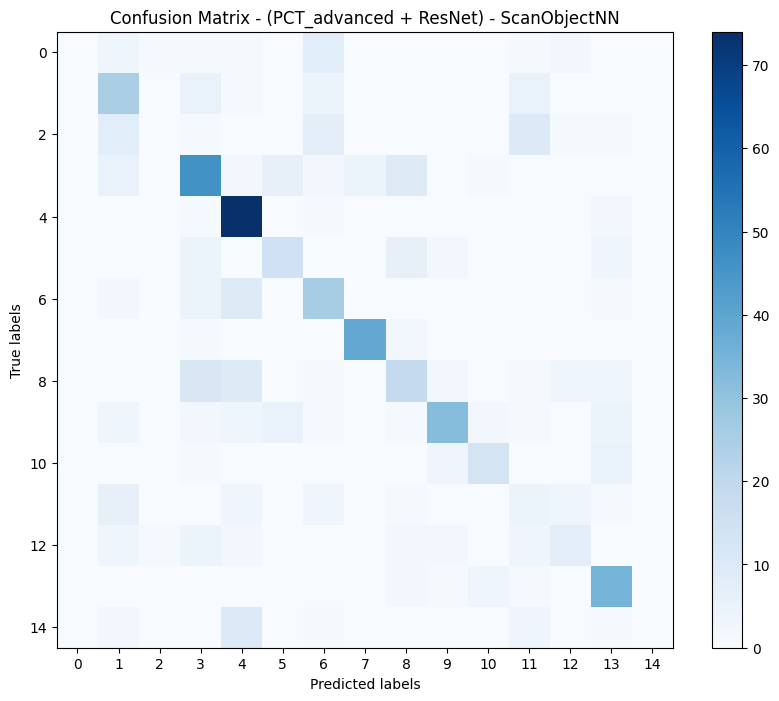

In [157]:
# Compute the confusion matrix
y_pred = model_tl.predict(feats_test)
if dataset == 'ModelNet40':
  cm = confusion_matrix(labels_test.reshape(-1,1), y_pred)
elif dataset == 'ScanObjectNN':
  cm = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - (" + exp_name + ') - ' + dataset)
plt.xticks(np.arange(len(classes_labels)))
plt.show()

In [158]:
if dataset == 'ModelNet40':
  print(f"Experiment = {exp_name} Dataset = {dataset} : Accuracy = {model_tl.score(feats_test, labels_test.reshape(-1,1))}")
elif dataset == 'ScanObjectNN':
  print(f"Experiment = {exp_name} Dataset = {dataset} : Accuracy = {model_tl.score(feats_test, labels_test)}")

Experiment = PCT_advanced + ResNet Dataset = ScanObjectNN : Accuracy = 0.576592082616179


### Plot Embeddings


In [ ]:
feats__test_array.shape

(156, 256)

In [ ]:
len(labels_test_int)

[9, 36, 9, 33, 9, 30, 30, 36, 9, 30, 9, 9, 9, 9, 9, 36, 9, 9, 9, 30, 9, 9, 9, 36, 9, 9, 33, 9, 33, 36, 9, 33, 30, 9, 9, 33, 36, 9, 9, 33, 30, 9, 9, 9, 30, 9, 9, 30, 9, 33, 33, 9, 36, 30, 9, 30, 30, 9, 9, 33, 9, 36, 9, 9, 9, 33, 9, 9, 9, 9, 30, 33, 30, 36, 9, 30, 9, 9, 9, 9, 30, 33, 9, 9, 33, 9, 33, 30, 9, 30, 36, 30, 30, 33, 9, 9, 36, 30, 36, 30, 9, 30, 33, 9, 36, 9, 30, 9, 9, 36, 36, 9, 9, 9, 9, 9, 9, 36, 9, 33, 36, 33, 30, 36, 36, 36, 33, 36, 30, 33, 9, 33, 9, 9, 33, 30, 9, 9, 9, 9, 36, 9, 9, 30, 9, 33, 30, 9, 9, 9, 9, 9, 36, 9, 36, 9]


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import wandb
wandb.init(project='CT_Multimodal_Fusion',name="Embeddings Plot 2")

cols = labels_test_int

#per ogni riga di feats__test_array aggiungere una colonna prendendo l'elemento corrente da labels_test_int
new_column = np.array(labels_test_int).reshape(-1, 1)
embedding_to_project = np.column_stack((feats__test_array, new_column))

wandb.log({
    "embeddings": wandb.Table(
        columns = list(range(1, 258)),
        data    = embedding_to_project
    )
})
wandb.finish()

Problem at: <ipython-input-57-c28d5ca2b659> 3 <module>


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_init.py", line 1144, in init
    run = wi.init()
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_init.py", line 607, in init
    manager._inform_init(settings=self.settings, run_id=self.settings.run_id)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_manager.py", line 209, in _inform_init
    svc_iface._svc_inform_init(settings=settings, run_id=run_id)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/service/service_sock.py", line 38, in _svc_inform_init
    self._sock_client.send(inform_init=inform_init)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/lib/sock_client.py", line 211, in send
    self.send_server_request(server_req)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/lib/sock_client.py", line 155, in send_server_request
    self._send_message(msg)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/lib/sock_client.py",

Exception: ignored

### Plot accuracy to wandb

In [ ]:
# initialize wandb
import wandb
wandb.init(project='CT_Multimodal_Fusion',name="Evaluation models")


# log the accuracy to wandb
if dataset == 'ModelNet40':
  wandb.run.name = exp_name+"-"+dataset
  wandb.log({"Test Accuracy "+exp_name+"-"+dataset: model_tl.score(feats_test, labels_test.reshape(-1,1))})
elif dataset == 'ScanObjectNN':
  wandb.run.name = exp_name+"-"+dataset
  wandb.log({"Test Accuracy "+exp_name+"-"+dataset: model_tl.score(feats_test, labels_test)})
elif choice == 5:
  wandb.log({exp_name: model_tl.score(feats__test_array, labels_test_int)})



# finalize the wandb run
wandb.join()

wandb: Currently logged in as: rucci-2053183 (sapienza_ml_2022_23). Use `wandb login --relogin` to force relogin


Vanilla + Vision Transfomer,▁
Vanilla + Vision Transfomer,0.87179


# RESULTS ✔︎✔︎✔︎✓✓✓✓✓✔︎✔︎✔︎

### LOSSES
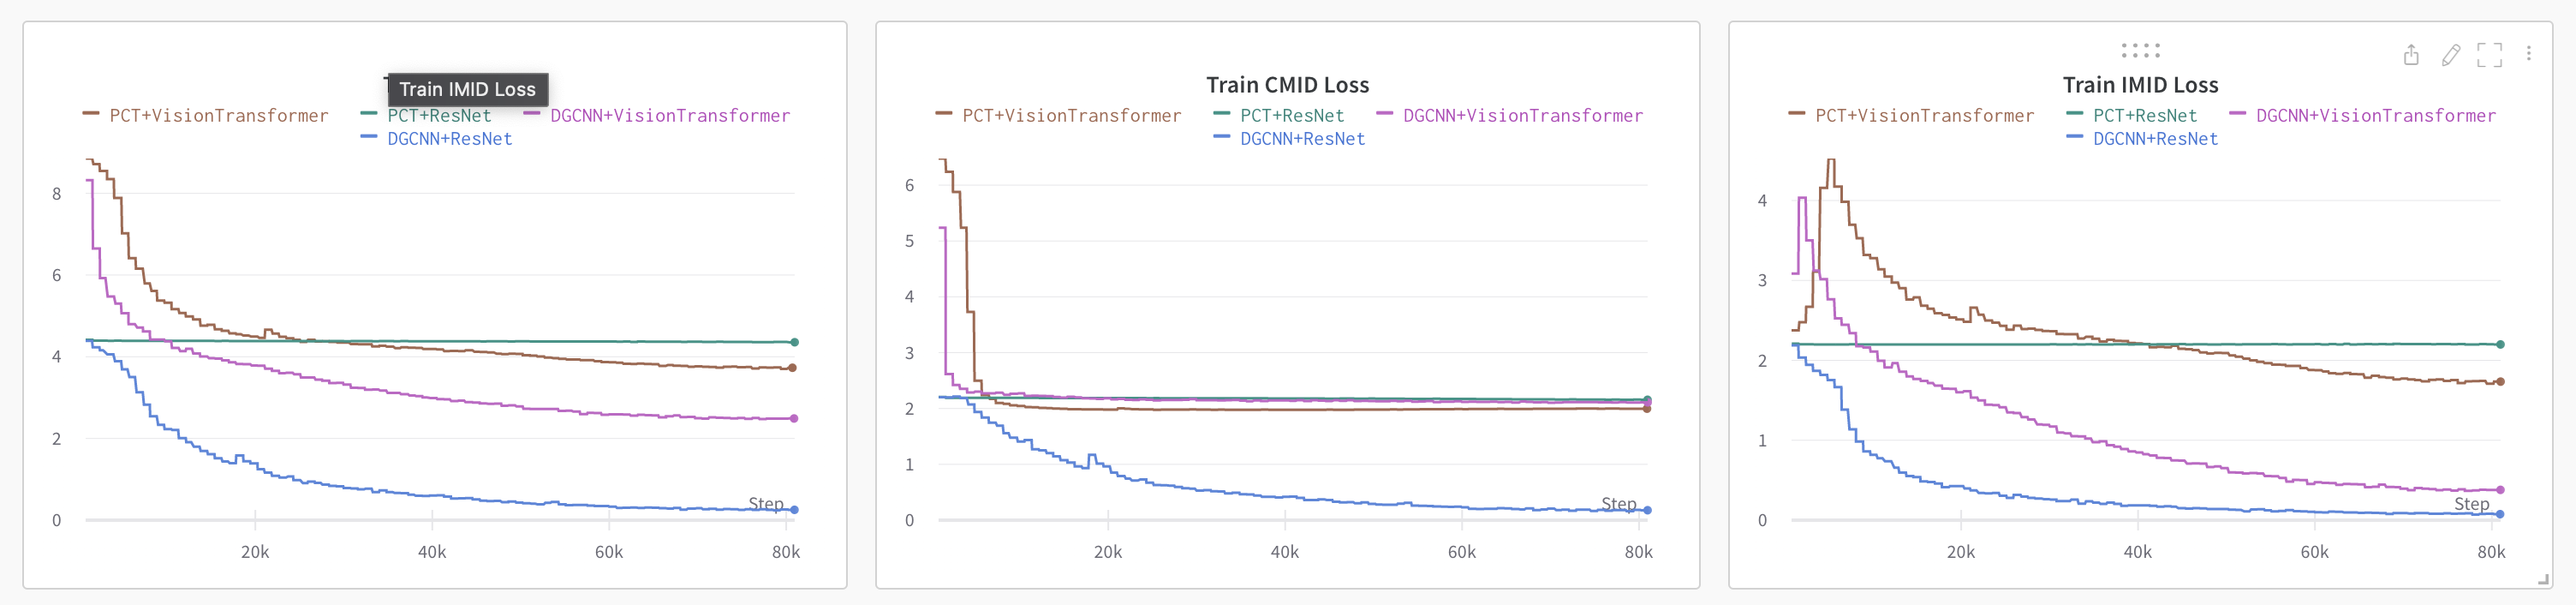

### TRAIN ACCURACY
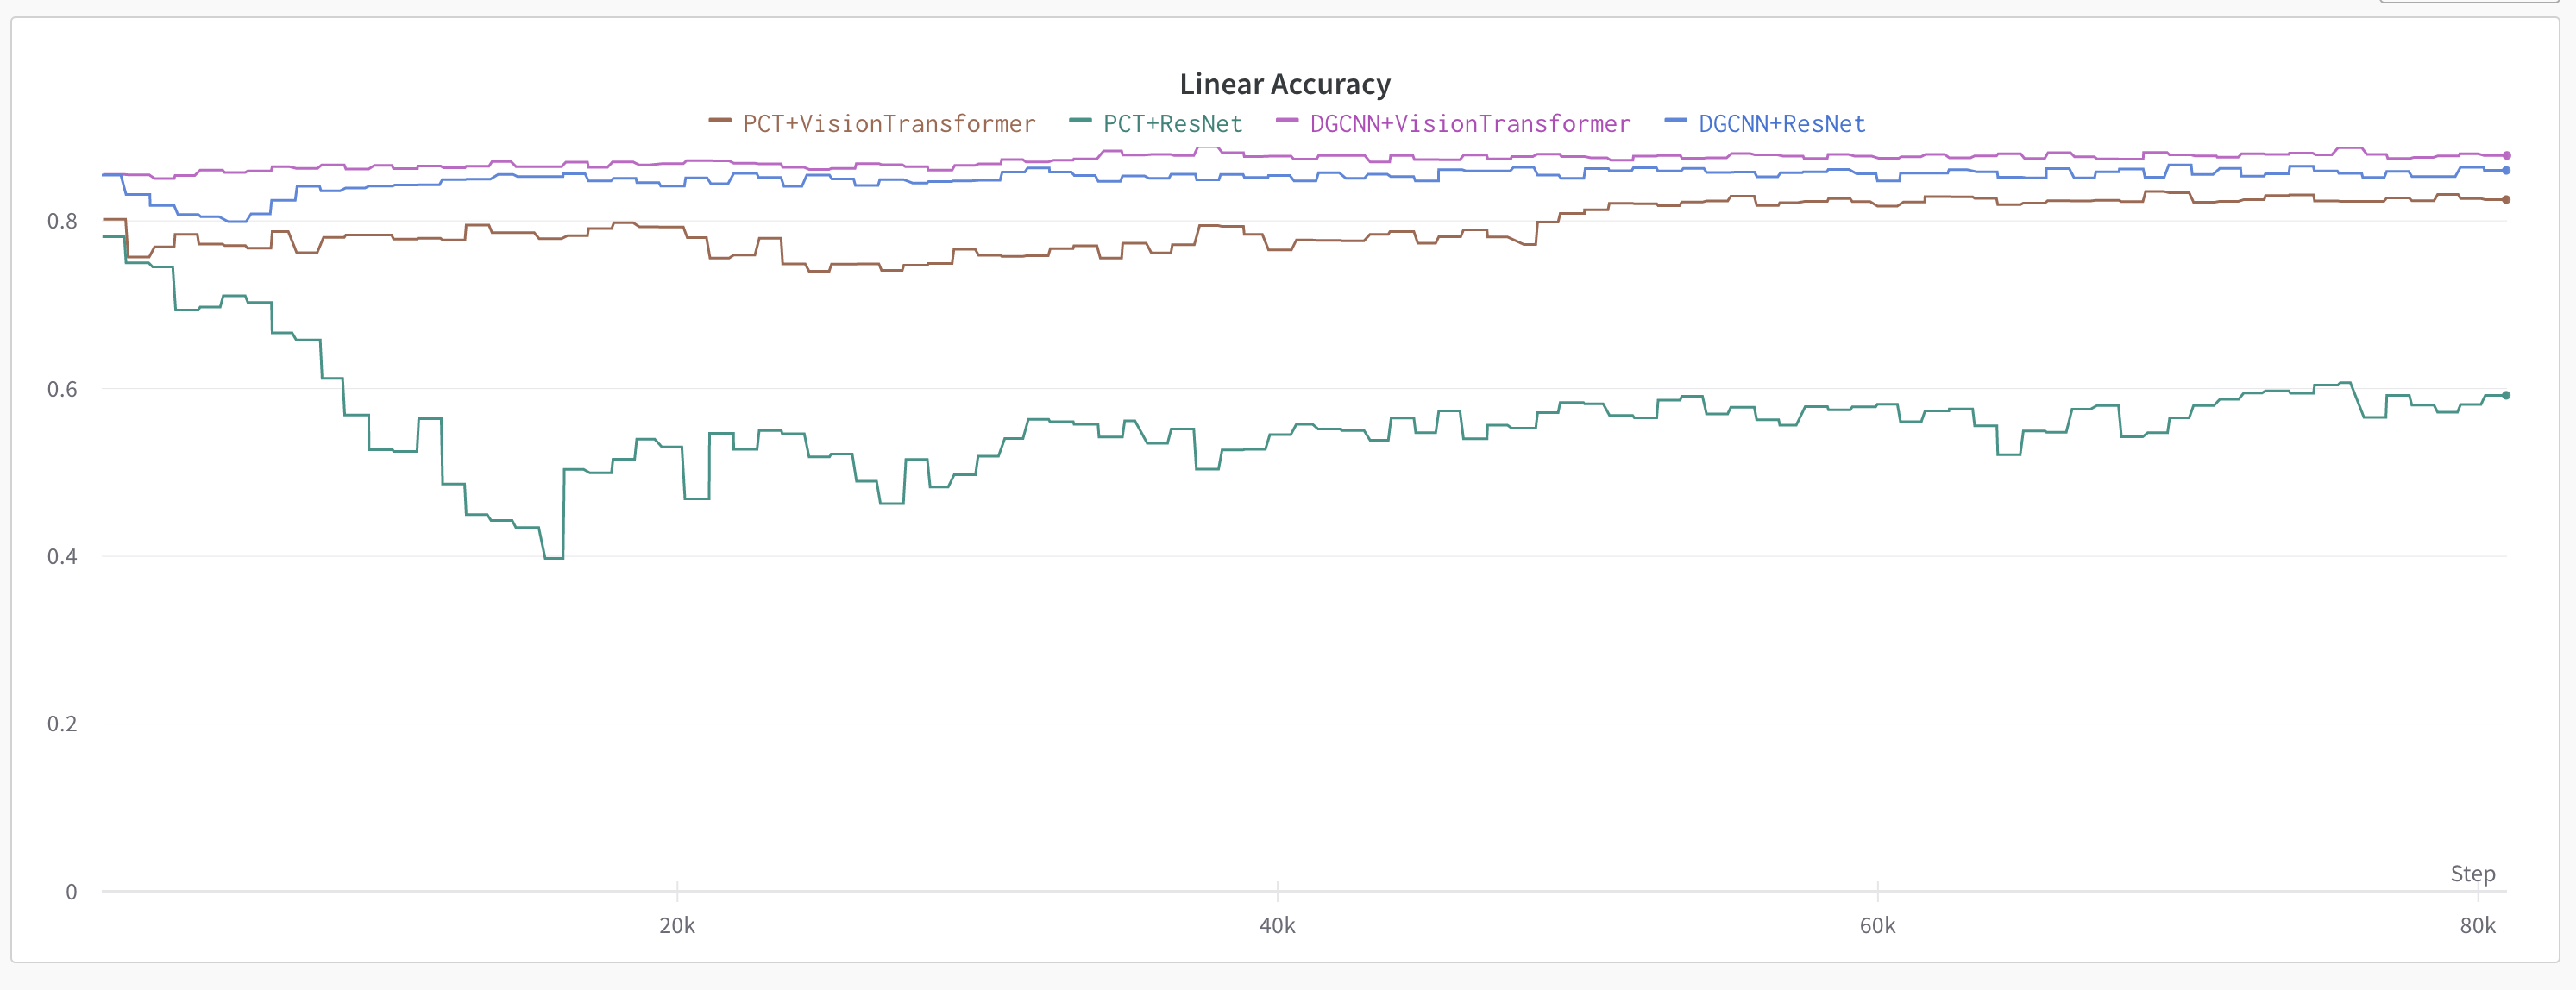

### TEST ACCURACY

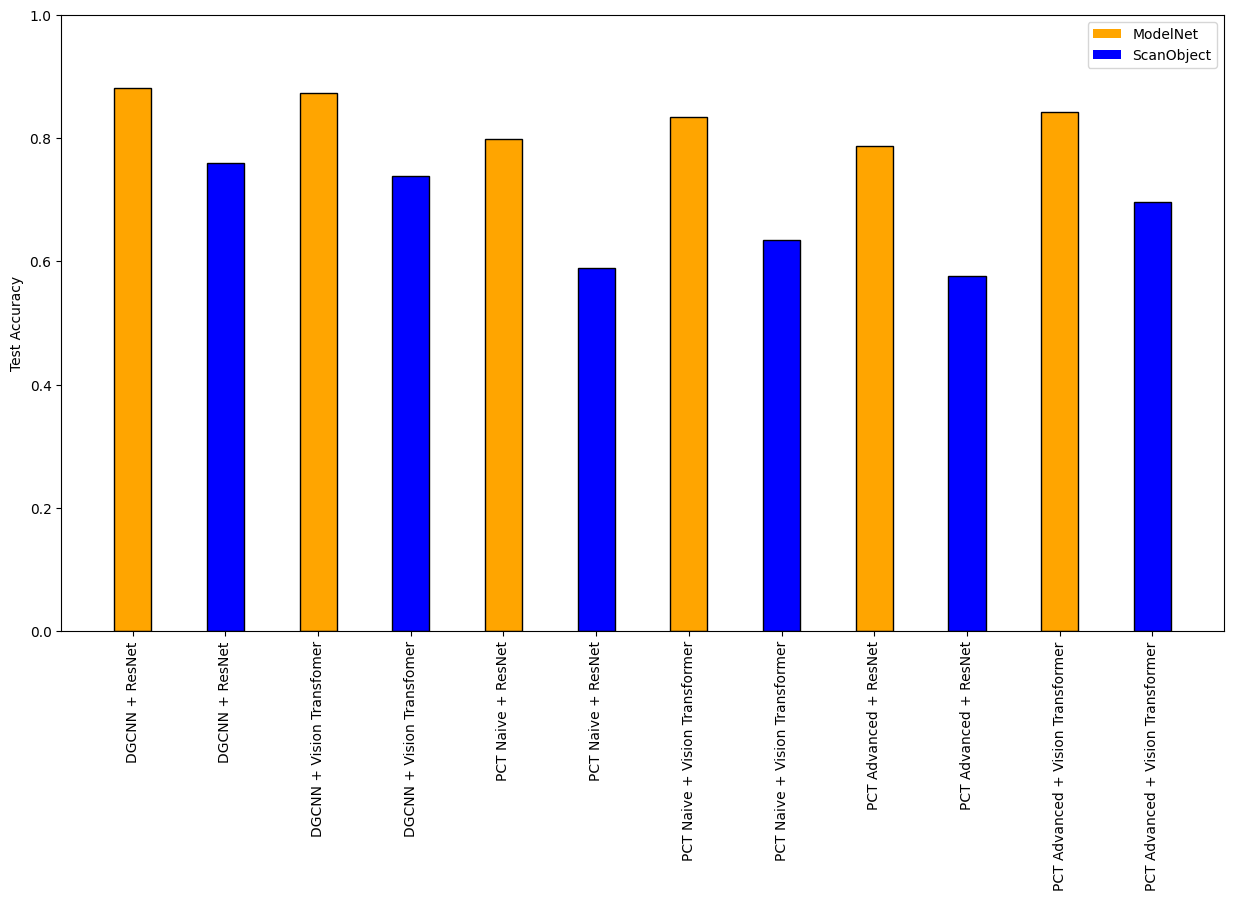

In [159]:
import matplotlib.pyplot as plt

#values = [ 0.8626 , 0.7418 , 0.8432 , 0.6661 , 0.6422 , 0.3907 , 0.7917, 0.5336  ]
#labels = ["DGCNN + ResNet", "DGCNN + ResNet", "DGCNN + Vision Transfomer", "DGCNN + Vision Transfomer", "PCT + ResNet", "PCT + ResNet", "PCT + Vision Transfomer", "PCT + Vision Transfomer"]
values = [ 0.8808, 0.7590, 0.8735, 0.7383, 0.7978, 0.5886, 0.8350, 0.6351, 0.7864, 0.5765, 0.8419, 0.6970 ]
labels = ["DGCNN + ResNet", "DGCNN + ResNet", "DGCNN + Vision Transfomer", "DGCNN + Vision Transfomer", "PCT Naive + ResNet", "PCT Naive + ResNet", "PCT Naive + Vision Transformer", "PCT Naive + Vision Transformer", "PCT Advanced + ResNet", "PCT Advanced + ResNet", "PCT Advanced + Vision Transformer", "PCT Advanced + Vision Transformer"]

fig, ax = plt.subplots(figsize=(15, 8))

color = ['orange' if i%2 == 0 else 'blue' for i in range(len(values))]
ax.bar(range(len(values)), values, color=color, width=0.4, edgecolor='black', align='center')

ax.set_ylim([0, 1])
ax.set_xticks(range(len(values)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Test Accuracy")

blue_patch = plt.Rectangle((0,0),1,1,fc="blue")
orange_patch = plt.Rectangle((0,0),1,1,fc="orange")

ax.legend([orange_patch, blue_patch], ["ModelNet", "ScanObject"])

plt.show()


### Observation

As we can see the DGCNN + RESNET model has the highest train accuracy but also our new approach for the task based on PCT + VIT has a good accuracy (at least for the purpose of this project).

We based the evaluation on two different datasets: modelnet-40 (syntehetic) and ScanObject (real).

The two plots show us the crucial information that all models presented in this project perform better with synthetic dataset and this happens probably because the learned features are not so precise for real dataset.

We have proof of this by plotting the two confusion matrices for example of the model with PCT + VIT that show us the big difference between synthetic and real object classification.

As we can see the model is able to better classify synthetic classes of objects while in real world it performs well only on class 4 (chairs).

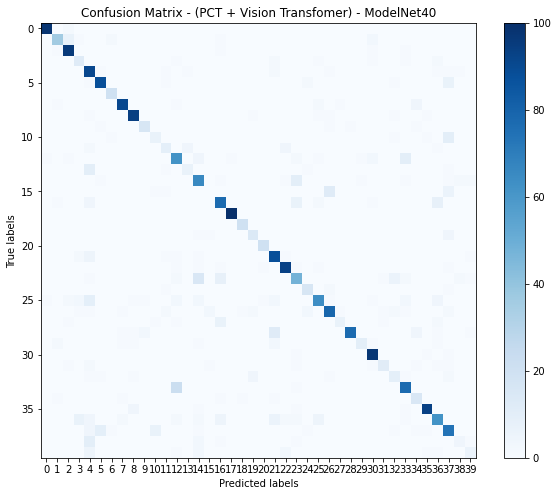




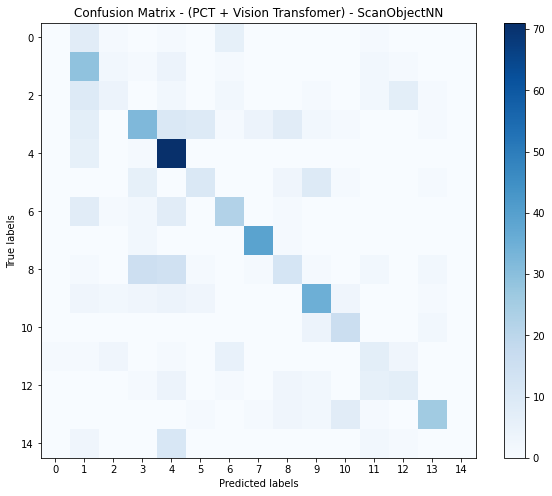


### NUMBER OF PARAMETERS

| Name     | Type     | Params   |
|----------|----------|----------|
| point_model | DGCNN | 3.0M |
| img_model | ResNet | 24.7M |

Trainable 27.7M
Non Trainable 0


| Name     | Type     | Params   |
|----------|----------|----------|
| point_model | DGCNN | 3.0M |
| img_model | Vit | 304M |

Trainable 3.6M
Non Trainable 304M


| Name     | Type     | Params   |
|----------|----------|----------|
| point_model | PCT | 3.1M |
| img_model | ResNet | 24.7M |

Trainable 27.7M
Non Trainable 0M


| Name     | Type     | Params   |
|----------|----------|----------|
| point_model | PCT | 3.1M |
| img_model | Vit | 304M |

Trainable 3.7M
Non Trainable 304M





Looking at the trainable parameters, our models have almost 1/10 of the parameters (Trainable) of the reference paper. However looking at the accuracy on the test set they still have nice performances.

Especially for DGCNN + ViT we suppose that training this model with more classes and specializing better the invariant head will lead to better performance.

# REFERENCES 🙏🏻🙏🏻🙏🏻🙏🏻🙏🏻

[1] CrossPoint: Self-Supervised Cross-Modal Contrastive Learning for 3D Point Cloud Understanding
Mohamed Afham, Isuru Dissanayake, Dinithi Dissanayake, Amaya Dharmasiri, Kanchana Thilakarathna, Ranga Rodrigo

[2] PCT: Point cloud transformer
Meng-Hao Guo, Jun-Xiong Cai, Zheng-Ning Liu, Tai-Jiang Mu, Ralph R. Martin, Shi-Min Hu

[3] Dynamic Graph CNN for Learning on Point Clouds
Yue Wang, Yongbin Sun, Ziwei Liu, Sanjay E. Sarma, Michael M. Bronstein, Justin M. Solomon

[4] Vision Transformers: State of the Art and Research Challenges Bo-Kai Ruan, Hong-Han Shuai, Wen-Huang Cheng

[5] Deep Residual Learning for Image Recognition
Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun


[DGCNN](https://github.com/WangYueFt/dgcnn)
[PCT] (https://github.com/qinglew/PointCloudTransformer)
